<a href="https://colab.research.google.com/github/Anson422/Anson-Eva-Valerie/blob/main/Text%20Analysis/Code_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Anson422/Anson-Eva-Valerie.git #clone the repository to the local machine

Cloning into 'Anson-Eva-Valerie'...
remote: Enumerating objects: 5381, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 5381 (delta 145), reused 58 (delta 58), pack-reused 5205 (from 2)
Receiving objects: 100% (5381/5381), 9.01 GiB | 73.02 MiB/s, done.
Resolving deltas: 100% (1823/1823), done.
Updating files: 100% (2887/2887), done.


In [2]:
!apt-get update
!apt-get install -y poppler-utils tesseract-ocr
!pip install PyPDF2 pycryptodome pymupdf pdfplumber pdf2image pytesseract --upgrade


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,197 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,563 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-upda

In [5]:
#Checking if the cloning was successfull
# Navigate to the cloned repository folder
repository_path = '/content/Anson-Eva-Valerie'

if os.path.exists(repository_path):
    print("Repository cloned successfully!")
    print("Files in the repository:", os.listdir(repository_path))
else:
    print("Repository cloning failed.")

Repository cloned successfully!
Files in the repository: ['Text Analysis', 'hello.ipynb', '.git', 'Stacked Bar Chart', 'Choropleth Map Analysis', 'README.md']


In [4]:
#install the necessary libraries
import os
import PyPDF2
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from PyPDF2 import PdfReader
import fitz  # PyMuPDF
import warnings
from collections import defaultdict
import pytesseract
import warnings
import pdfplumber
from pdf2image import convert_from_path
import sys
import logging


In [6]:
# Suppress all warnings globally (if needed)
warnings.simplefilter("ignore")

In [7]:
#suppress only PyPDF2 warnings
logging.getLogger("PyPDF2").setLevel(logging.ERROR)  # Suppress PyPDF2 warnings globally

# Function to extract text using PyPDF2
def extract_text_with_pypdf2(pdf_path):
    text = ""
    try:
        reader = PdfReader(pdf_path)
        for page in reader.pages:
            text += page.extract_text() or ""
    except Exception as e:
        print(f"PyPDF2 failed for {pdf_path}: {e}")
    return text

# Function to extract text using pdfplumber
def extract_text_with_pdfplumber(pdf_path):
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() or ""
    except Exception as e:
        print(f"pdfplumber failed for {pdf_path}: {e}")
    return text

# Function to extract text using OCR
def extract_text_with_ocr(pdf_path):
    text = ""
    try:
        images = convert_from_path(pdf_path)
        for image in images:
            text += pytesseract.image_to_string(image)
    except Exception as e:
        print(f"OCR failed for {pdf_path}: {e}")
    return text

# Unified function to extract text
def extract_text_from_pdf(pdf_path):
    # Try PyPDF2
    text = extract_text_with_pypdf2(pdf_path)
    if not text.strip():  # Fallback to pdfplumber if PyPDF2 fails
        text = extract_text_with_pdfplumber(pdf_path)
    if not text.strip():  # Fallback to OCR if pdfplumber also fails
        text = extract_text_with_ocr(pdf_path)
    return text

In [8]:
# Define the folder containing the EU energy publications in 2024
EU_Energy_publications_2024 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2024'

In [9]:
# List of keyword categories and their synonyms
keyword_groups = {
    "LNG": ["LNG", "liquid natural gas"],
    "Renewable Energy": ["renewable", "clean energy", "alternative energy", "green energy"],
    "Pipeline Alternatives": ["pipeline alternatives"],
    "Coal": ["coal"],
    "Oil": ["oil", "crude oil", "petroleum"],
    "Natural Gas": ["natural gas", "methane", "shale gas", "pipeline gas"],
    "Nuclear": ["nuclear", "uranium", "fission", "fusion"],
    "Hydro": ["hydro", "water power", "hydropower", "dam energy"],
    "Biofuels": ["biofuels", "biodiesel", "bioethanol"],
    "Geothermal": ["geothermal", "ground source heat", "deep geothermal"],
    "Solar": ["solar", "photovoltaic", "PV", "solar thermal", "solar panels", "solar farms"],
    "Wind": ["wind", "offshore wind", "onshore wind", "wind turbines", "wind farms"],
    "Wave Power": ["wave power", "ocean energy", "marine energy"],
    "Biogas": ["biogas", "biomethane"],
    "Biomass": ["biomass", "wood pellets", "agricultural waste", "energy crops"],
    "Tidal": ["tidal power", "tidal energy"],
    "Fossil Fuels": ["fossil fuels", "oil", "coal", "natural gas"],
}

# Initialize category counts
category_counts = {category: 0 for category in keyword_groups}


In [10]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2024):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2024, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2024 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2024)

Processing: resilience%20assessment-KJ0124002ENN.pdf
Processing: behavioural%20insights%20applied%20to%20policy-KJ0124189ENN.pdf
Processing: addressing%20the%20regional%20dimension%20of%20open%20strategic-KJNA31868ENN.pdf
Processing: strukturlotsen%20improving%20inter-municipal%20cooperation-MJ0524516ENN.pdf
Processing: europeans%20opinions%20about%20the%20european%20unions%20priorities-NAAO24004ENN.pdf
Processing: europeans%20attitudes%20towards%20eu%20energy%20policy-MJ0924678ENN.pdf
Processing: bulgaria%20and%20its%20collaboration%20with%20the%20joint%20research-KJ0624149ENN.pdf
Processing: fisa%202022-KI0323060ENN-compressed.pdf
Processing: clean%20energy%20technology%20observatory%20hydropower%20and-KJ0124070ENN.pdf
Processing: clean%20energy%20technology%20observatory%20early%20stage%20technologies-KJNA31807ENN.pdf
Processing: ramp-up%20and%20role%20of%20hydrogen-based%20power%20generation-MJ0524460ENN.pdf
Processing: smart%20cities%20marketplace%20newsletter%2030%20may%202024-MJ

In [11]:
# Sort the DataFrame by frequency in descending order
df_2024 = df_2024.sort_values(by="Frequency", ascending=False)


In [12]:
# Define a styled DataFrame with custom styles
styled_df_2024 = df_2024.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2024)

,Category,Frequency
7,Hydro,21974
1,Renewable Energy,16957
16,Fossil Fuels,13333
6,Nuclear,12371
10,Solar,11678
11,Wind,10570
4,Oil,6672
5,Natural Gas,5064
14,Biomass,4503
3,Coal,4001


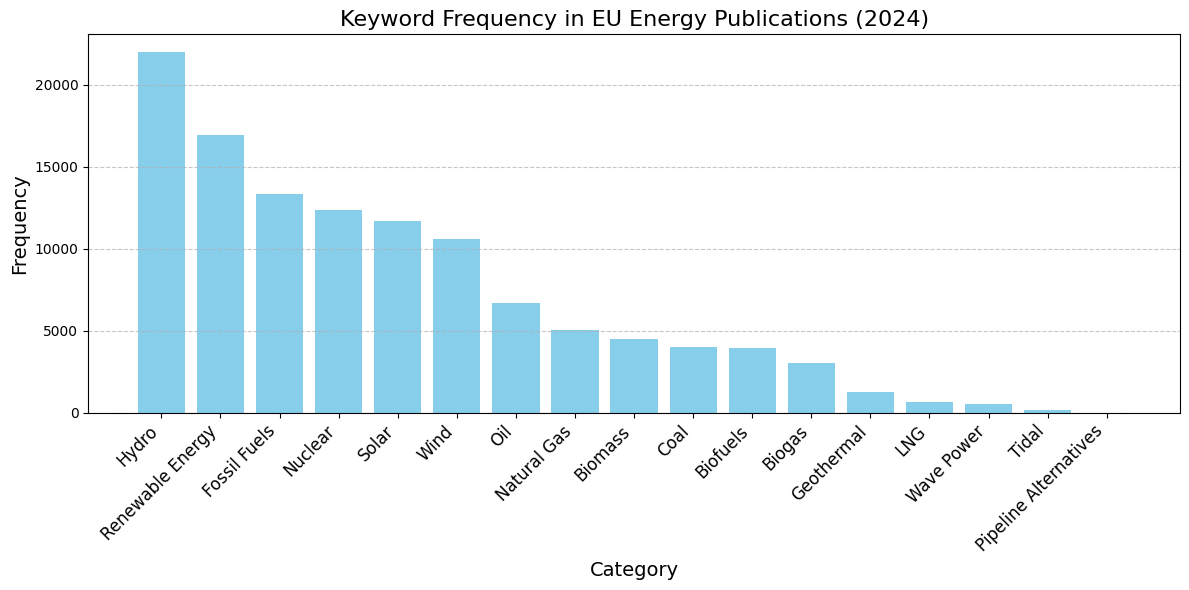

In [13]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2024["Category"], df_2024["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2024)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [14]:
# Define the folder containing the EU energy publications in 2019
EU_Energy_publications_2019 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2019'

In [15]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2019):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2019, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2019 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2019)

Processing: a%20bright%20future-QH0319395ENN.pdf
Processing: operating%20experience%20with%20digital%20i%26c%20systems%20at%20nuclear-KJNA29618ENN.pdf
Processing: study%20on%20consumer%20understanding%20of%20draft%20energy%20labels-KH0419169ENN.pdf
Processing: mapping%20threats%20to%20peace%20and%20democracy%20worldwide-QA0419443ENN.pdf
Processing: dg%20energy%20news%20december%202019-MJAF19012ENN.pdf
Processing: competitiveness%20of%20renewable%20heating%20and%20cooling%20industry-MJ0319525ENN.pdf
Processing: support%20to%20key%20activities%20of%20the%20european%20technology-KI0419135ENN.pdf
Processing: effect%20of%20high%20shares%20of%20renewables%20on%20power%20systems-MJ0319327ENN.pdf
Processing: position%20paper%20on%20water%20energy%20food%20and%20ecosystems-KJNA29509ENN.pdf
Processing: inea-QJAB19014ENN.pdf
Processing: dg%20energy%20news%20march%202019-MJAF19003ENN.pdf
Processing: tabletop%20exercise-KJNA29872ENN.pdf
Processing: do%20current%20regulatory%20frameworks%20in%20the%

In [16]:
# Sort the DataFrame by frequency in descending order
df_2019 = df_2019.sort_values(by="Frequency", ascending=False)

In [17]:
# Define a styled DataFrame with custom styles
styled_df_2019 = df_2019.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2019)

,Category,Frequency
7,Hydro,33978
16,Fossil Fuels,33878
1,Renewable Energy,30006
10,Solar,27543
6,Nuclear,23751
11,Wind,21288
4,Oil,19259
5,Natural Gas,10373
14,Biomass,9818
3,Coal,9081


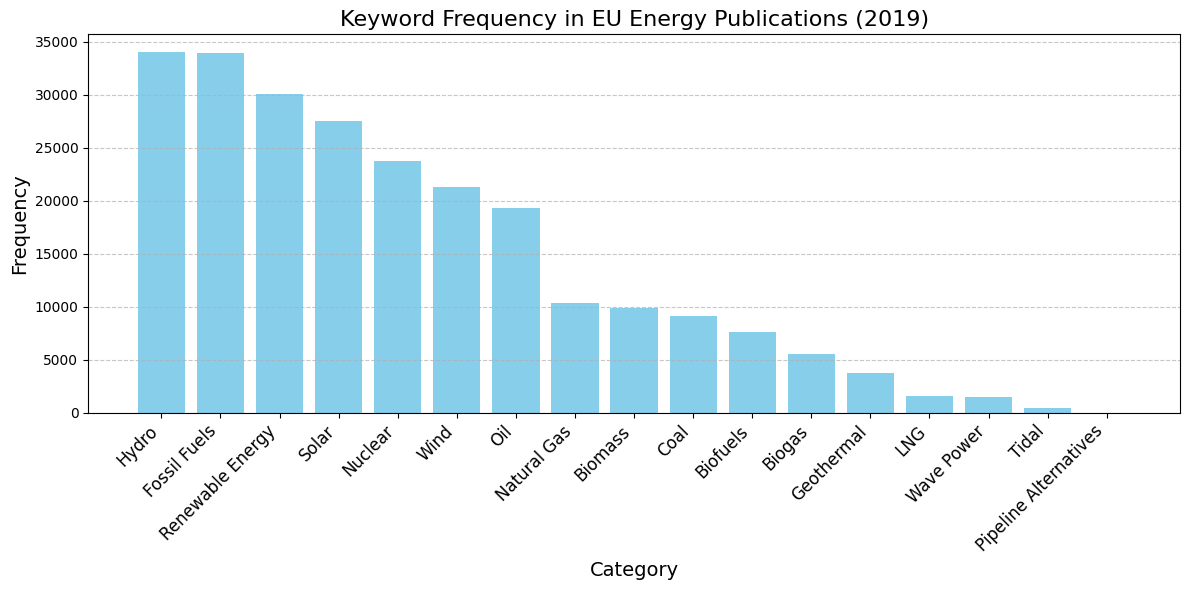

In [29]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2019["Category"], df_2019["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2019)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [19]:
# Define the folder containing the EU energy publications in 2020
EU_Energy_publications_2020 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2020'

In [20]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2020):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2020, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2020 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2020)

Processing: photovoltaic%20energy%20systems-KJNA30115ENN.pdf
Processing: ten%20issues%20to%20watch%20in%202020-QA0200011ENN.pdf
Processing: environmental%20statement%202020-QCAQ20001ENN.pdf
Processing: energy%20communities-KJNA30083ENN.pdf
Processing: impact%20of%20the%20use%20of%20offshore%20wind%20and%20other%20marine-QA0420605ENN.pdf
Processing: energy-efficient%20cloud%20computing%20technologies%20and-KK0320210ENN.pdf
Processing: consumer%20satisfaction%20kpis%20for%20the%20roll-out%20of%20smart-MJ0420643ENN.pdf
Processing: newsletter%20smart%20cities%20marketplace%2030%20september%202020-MJAL20003ENN.pdf
Processing: development%20of%20modular%20steel%20jacket%20for%20offshore%20windfarms-KINA30457ENN.pdf
Processing: low-maintenance%20fuel-cell%20systems%20for%20work%20and%20home-EG0220768ENN.pdf
Processing: newsletter%20smart%20cities%20marketplace%2013%20august%202020-MJAL20002ENN.pdf
Processing: reliable%20green%20power%20for%20off-grid%20communities-EG0420541ENN.pdf
Processing:

In [21]:
# Sort the DataFrame by frequency in descending order
df_2020 = df_2020.sort_values(by="Frequency", ascending=False)

In [27]:
# Define a styled DataFrame with custom styles
styled_df_2020 = df_2020.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2020)

,Category,Frequency
16,Fossil Fuels,61989
7,Hydro,52049
1,Renewable Energy,45312
10,Solar,44333
11,Wind,41784
4,Oil,35361
6,Nuclear,34632
5,Natural Gas,19118
3,Coal,17047
14,Biomass,14396


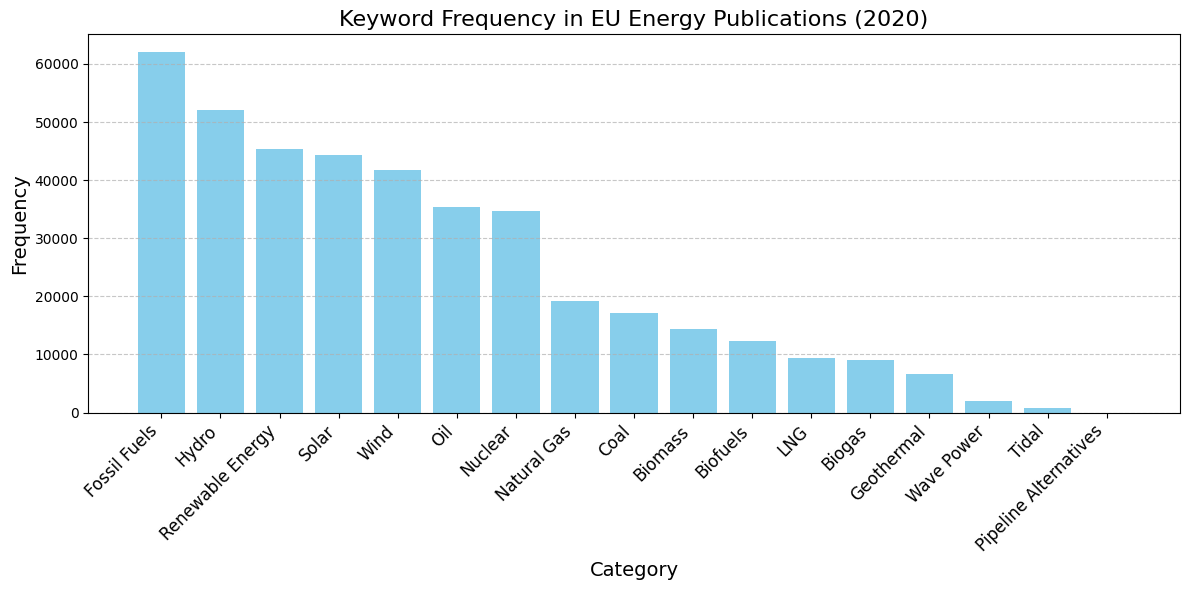

In [28]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2020["Category"], df_2020["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2020)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [24]:
# Define the folder containing the EU energy publications in 2021
EU_Energy_publications_2021 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2021'

In [30]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2021):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2021, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2021 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2021)

Processing: cinea%20european%20climate%20infrastructure%20and%20environment-EF0221483ENN.pdf
Processing: solar%20photovoltaic%20modules%20inverters%20and%20systems-KJNA30474ENN.pdf
Processing: 5g%20supply%20market%20trends-KK0521236ENN.pdf
Processing: geolocation%20of%20hydrogen%20production%20in%20the%20eu-MJ0320495ENN.pdf
Processing: implementation%20of%20the%20network%20code%20on%20requirements-MJ0921258ENN.pdf
Processing: dg%20energy%20news%20january%202021-MJAF21001ENN.pdf
Processing: renewable%20hydrogen%20and%20the%20%E2%80%9Cadditionality%E2%80%9D%20requirement-QMAX21036ENN.pdf
Processing: green%20growth%20jobs%20and%20social%20impacts-KH0921053ENN.pdf
Processing: chip-scale%20atomic%20clocks-KJNA30790ENN-compressed.pdf
Processing: european%20barriers%20in%20retail%20energy%20markets-MJ0221195ENN.pdf
Processing: good%20practice%20guide%20for%20validation%20of%20a%20waste%20characterisation-KJNA30761ENN.pdf
Processing: policy%20and%20regulatory%20challenges%20for%20the%20deploym

In [31]:
# Sort the DataFrame by frequency in descending order
df_2021 = df_2021.sort_values(by="Frequency", ascending=False)

In [32]:
# Define a styled DataFrame with custom styles
styled_df_2021 = df_2021.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2021)

,Category,Frequency
16,Fossil Fuels,87567
7,Hydro,76549
1,Renewable Energy,61874
10,Solar,53546
4,Oil,48909
6,Nuclear,48689
11,Wind,47452
5,Natural Gas,28846
3,Coal,22989
14,Biomass,21038


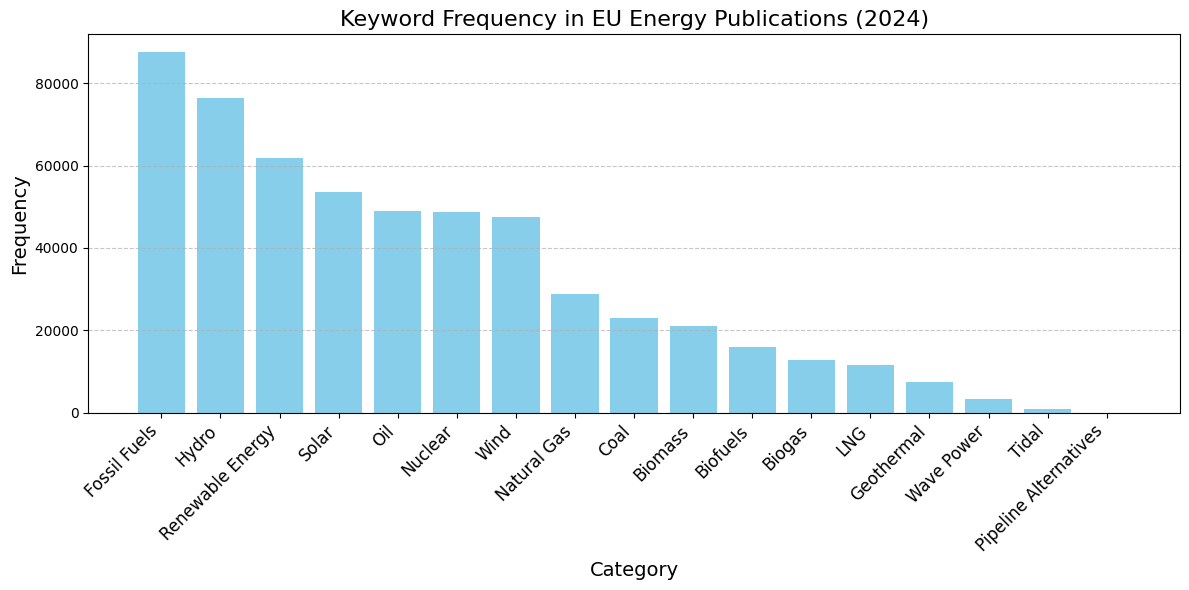

In [33]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2021["Category"], df_2021["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2024)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [34]:
# Define the folder containing the EU energy publications in 2022
EU_Energy_publications_2022 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2022'

In [35]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2022):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2022, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2022 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2022)

Processing: eu-africa%20global%20gateway%20investment%20package-NA0422209ENN.pdf
Processing: investors%20dialogue%20on%20energy%20newsletter%2022122022-MJAZ22004ENN.pdf
Processing: research%20and%20innovation%20to%20repower%20the%20eu-KI0122367ENN.pdf
Processing: 30%20years%20eu%20ecolabel-KH0322065ENN.pdf
Processing: further%20support%20to%20the%20preparation%20of%20an%20impact%20assessment-ML0221156ENN.pdf
Processing: dg%20energy%20news%20february%202022-MJAF22002ENN.pdf
Processing: western%20sanctions%20and%20russia-QA0822057ENN.pdf
Processing: smart%20grid%20laboratories%20inventory%202022-KJNA31062ENN.pdf
Processing: baseline%20assessment%20and%20monitoring%20of%20water%20resources-LBNA27749ENN.pdf
Processing: fly%20the%20green%20deal-KI0521325ENN.pdf
Processing: global%20energy%20and%20climate%20outlook%202022-KJNA31355ENN.pdf
Processing: protecting%20your%20ip%20in%20the%20green%20technology%20sector-EA0622080ENN.pdf
Processing: rmis%20newsletter%20special%20edition%20march%2020

In [36]:
# Sort the DataFrame by frequency in descending order
df_2022 = df_2022.sort_values(by="Frequency", ascending=False)

In [37]:
# Define a styled DataFrame with custom styles
styled_df_2022 = df_2022.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2022)

,Category,Frequency
16,Fossil Fuels,108702
7,Hydro,97363
1,Renewable Energy,80115
10,Solar,66624
4,Oil,62784
11,Wind,58810
6,Nuclear,55796
5,Natural Gas,34224
3,Coal,26540
14,Biomass,25844


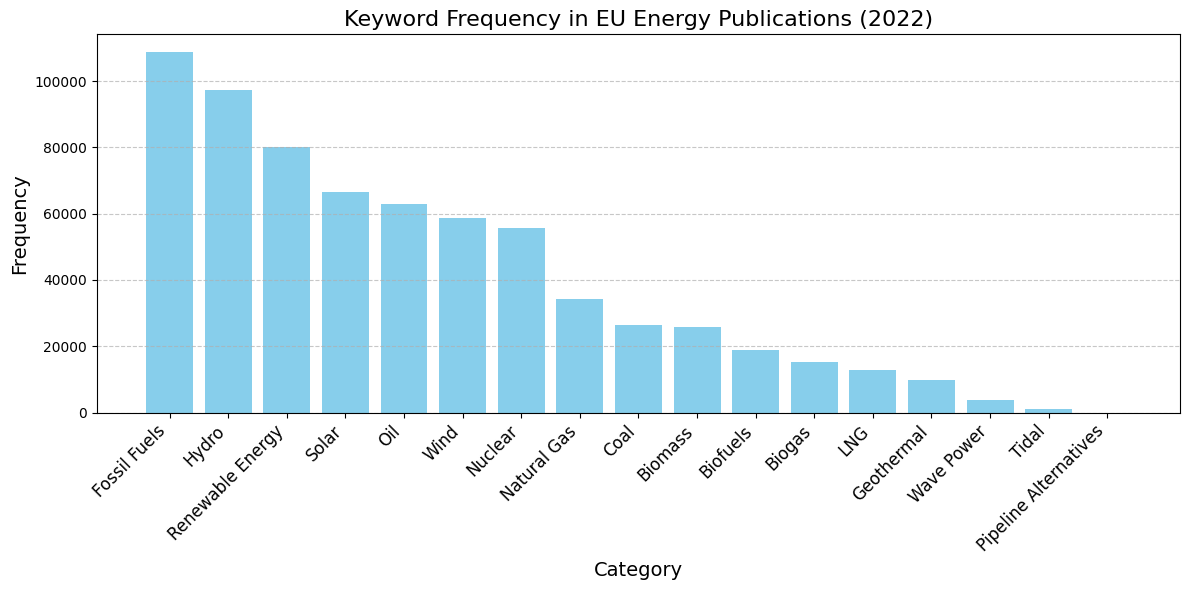

In [38]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2022["Category"], df_2022["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2022)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [39]:
# Define the folder containing the EU energy publications in 2023
EU_Energy_publications_2023 = '/content/Anson-Eva-Valerie/Text Analysis/EU publications about Energy in 2023'

In [40]:
# Loop through all PDFs in the folder
for filename in os.listdir(EU_Energy_publications_2023):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(EU_Energy_publications_2023, filename)
        print(f"Processing: {filename}")
        try:
            # Extract text and count keywords
            text = extract_text_from_pdf(pdf_path).lower()
            for category, synonyms in keyword_groups.items():
                count = sum(text.count(keyword.lower()) for keyword in synonyms)
                category_counts[category] += count
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Convert results to a DataFrame for better visualization
df_2023 = pd.DataFrame(category_counts.items(), columns=["Category", "Frequency"])
print(df_2023)

Processing: the%20eu%20regulatory%20framework%20for%20market%20risk%20and%20prudent-DZAH23002ENN.pdf
Processing: set%20plan20progress20report202023-KJNA31719ENN_compressed.pdf
Processing: green%20deal%20call%20projects%20success%20stories-KIBK23009ENN.pdf
Processing: study%20on%20the%20long-term%20linkages%20between%20climate%20objectives-ML0523558ENN.pdf
Processing: boosting%20hydrogen%20through%20a%20european%20hydrogen%20bank-NA0423312ENN.pdf
Processing: clean%20energy%20technology%20observatory%20smart%20grids%20in-KJNA31673ENN.pdf
Processing: study%20to%20develop%20eu%20level%20simplified%20cost%20options-KN0923408ENN.pdf
Processing: guide%20on%20financing%20the%20green%20energy%20transition%20of-KL0323424ENN.pdf
Processing: local%20and%20regional%20authorities%20in%20the%20governance%20of-QG0723344ENN.pdf
Processing: overview%20of%20seismic%20and%20energy%20retrofit%20technologies-KJNA31685ENN.pdf
Processing: enabling%20energy%20communities-KN0423998ENN.pdf
Processing: small%20mo

In [41]:
# Sort the DataFrame by frequency in descending order
df_2023 = df_2023.sort_values(by="Frequency", ascending=False)

In [42]:
# Define a styled DataFrame with custom styles
styled_df_2023 = df_2023.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ADD8E6'),  # Header background color
                                 ('color', 'white'),               # Header text color
                                 ('font-weight', 'bold'),          # Bold header text
                                 ('text-align', 'center')]},       # Center-align header text
    {'selector': 'td', 'props': [('padding', '8px'),               # Cell padding
                                 ('text-align', 'center')]},       # Center-align cell text
    {'selector': 'table', 'props': [('width', '80%'),              # Table width
                                    ('margin', 'auto'),            # Center the table
                                    ('border', '1px solid black'), # Add border
                                    ('border-collapse', 'collapse')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Alternate row colors
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]}   # Alternate row colors
])

# Display the styled DataFrame
display(styled_df_2023)

,Category,Frequency
16,Fossil Fuels,124091
7,Hydro,122101
1,Renewable Energy,96921
10,Solar,77156
4,Oil,72778
11,Wind,68766
6,Nuclear,64139
5,Natural Gas,37522
14,Biomass,31601
3,Coal,29252


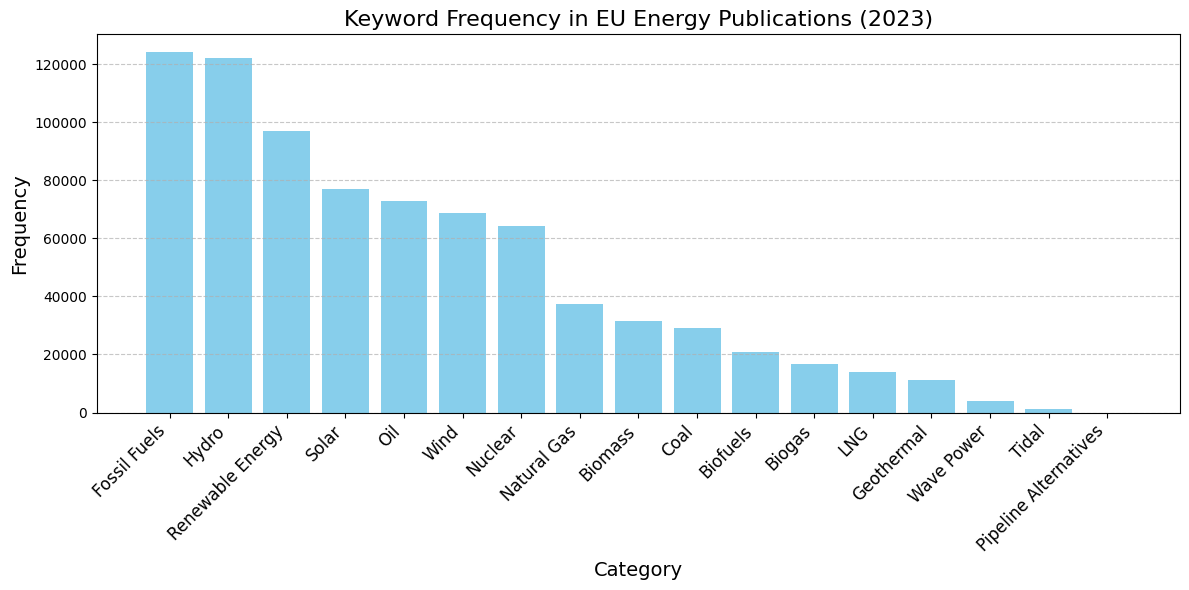

In [43]:
# Create a bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df_2023["Category"], df_2023["Frequency"], color='skyblue')

# Add titles and labels
plt.title("Keyword Frequency in EU Energy Publications (2023)", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

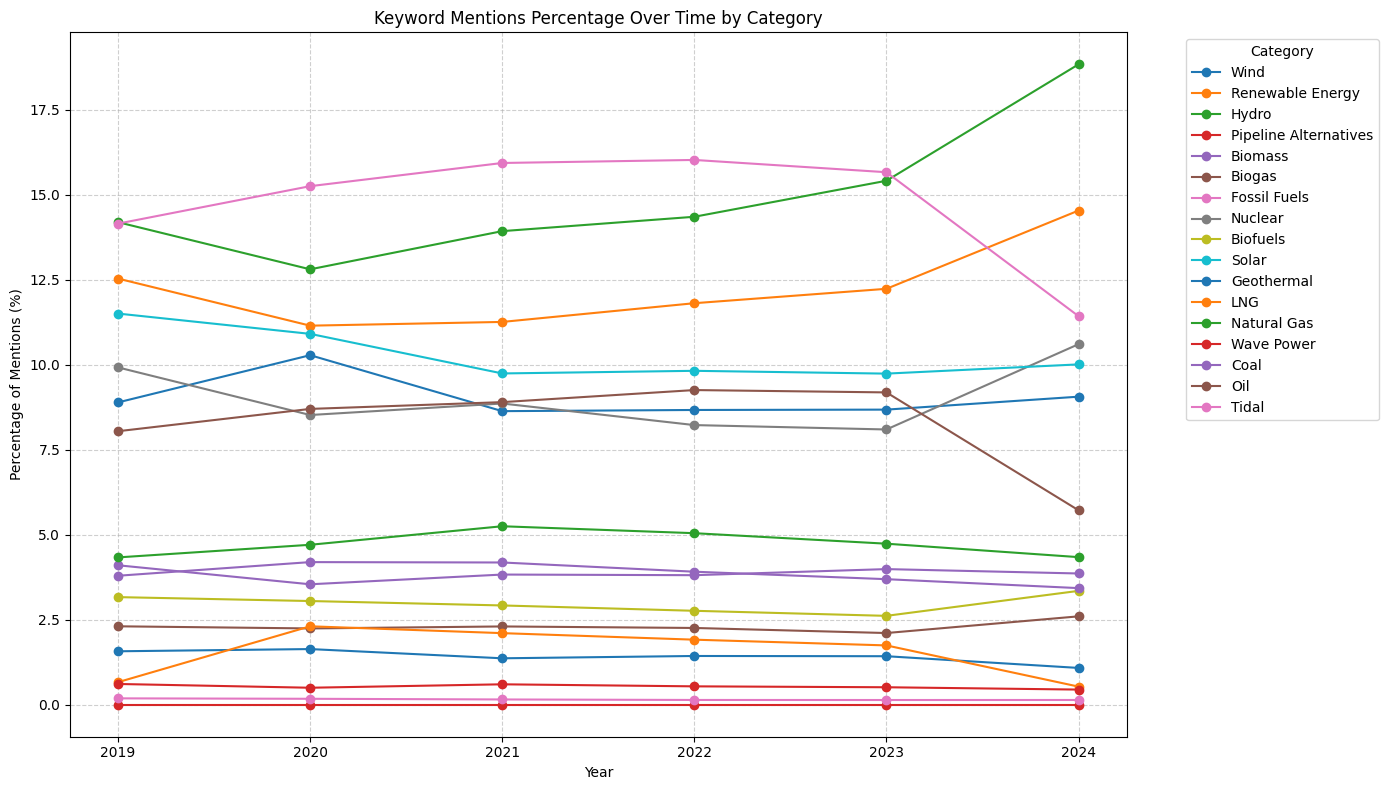

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_2019, df_2020, df_2021, df_2022, and df_2023 are already defined
# Example DataFrames for testing (replace with your actual data)
# df_2019 = pd.DataFrame({"Category": ["A", "B", "C"], "Frequency": [10, 20, 30]})
# df_2020 = pd.DataFrame({"Category": ["A", "B", "C"], "Frequency": [15, 25, 35]})
# df_2021 = pd.DataFrame({"Category": ["A", "B", "C"], "Frequency": [20, 30, 40]})
# df_2022 = pd.DataFrame({"Category": ["A", "B", "C"], "Frequency": [25, 35, 45]})
# df_2023 = pd.DataFrame({"Category": ["A", "B", "C"], "Frequency": [30, 40, 50]})

# Combine DataFrames into a single DataFrame for plotting
years = [2019, 2020, 2021, 2022, 2023, 2024]
dfs = [df_2019, df_2020, df_2021, df_2022, df_2023, df_2024]

# Ensure all DataFrames have the same categories and merge them
all_categories = set().union(*(df["Category"] for df in dfs))
data = {"Year": []}
for category in all_categories:
    data[category] = []

for year, df in zip(years, dfs):
    data["Year"].append(year)
    total_keywords = df["Frequency"].sum()  # Total keywords for the year
    for category in all_categories:
        freq = df[df["Category"] == category]["Frequency"].sum() if category in df["Category"].values else 0
        percentage = (freq / total_keywords * 100) if total_keywords > 0 else 0  # Convert to percentage
        data[category].append(percentage)

# Create a consolidated DataFrame
df_combined = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(14, 8))
for category in all_categories:
    plt.plot(df_combined["Year"], df_combined[category], marker="o", label=category)

plt.xlabel("Year")
plt.ylabel("Percentage of Mentions (%)")
plt.title("Keyword Mentions Percentage Over Time by Category")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
